In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, roc_curve, precision_score, recall_score, make_scorer
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier


In [33]:
data = pd.read_csv('takehome_ds_written.csv', index_col=0)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [34]:
data.head()

merchant                 time  amount_usd_in_cents
1  faa029c6b0  2034-06-17 23:34:14                 6349
2  ed7a7d91aa  2034-12-27 00:40:38                 3854
3  5608f200cf  2034-04-30 01:29:42                  789
4  15b1a0d61e  2034-09-16 01:06:23                 4452
5  4770051790  2034-07-22 16:21:42                20203

In [35]:
data.shape

(1513719, 3)

In [36]:
# some hyperparameters 
# here I want to only use data who has txn records after this threshold since the rest part 
# lacks data in past half years.
thres_date = '2033-07-01'
spot = '2035-01-01'

churn_day = 30 # no transaction in recent 30 days means churn

In [37]:
def preprocess_data(data, spot):
    data['date'] = pd.to_datetime(data['time'])  # transfer str to date

    # create a user table with primary key of merchant id
    user = pd.DataFrame(data.merchant.drop_duplicates())
    user.index = user.merchant

    # get some features of each user, with the most recent txn date, and txn amount description
    user['last_txn_date'] = data[['merchant', 'date']].groupby('merchant').max() 
    user = user[user['last_txn_date'] > pd.to_datetime(thres_date)]
    user['avg_amount'] = data[['merchant', 'amount_usd_in_cents']].groupby('merchant').mean()
    user['med_amount'] = data[['merchant', 'amount_usd_in_cents']].groupby('merchant').median()
    user['total_amount'] = data[['merchant', 'amount_usd_in_cents']].groupby('merchant').sum()
    user['total_txn_times'] = data[['merchant', 'amount_usd_in_cents']].groupby('merchant').count()
    
    # get the txn gap to define churn
    user['gap_last_txn'] = (pd.to_datetime(spot) - user['last_txn_date']).dt.days
    user['churn'] = (user['gap_last_txn'] >= churn_day).astype(int)
    
    # Simply use a pareto principle to determine the threshold might work.
    threshold_amount = user.total_amount.quantile(0.8)
    threshold_times = user.total_txn_times.quantile(0.8)

    # above the threshold I label them as 1
    user['Frequency'] = (user['total_txn_times'] > threshold_times).astype(int)
    user['Monetary'] = (user['total_amount'] > threshold_amount).astype(int)
    
    return user

In [38]:
user = preprocess_data(data, spot)

In [39]:
user

merchant       last_txn_date     avg_amount  med_amount  \
merchant                                                                
faa029c6b0  faa029c6b0 2034-12-30 20:57:25   16729.992647     14599.0   
ed7a7d91aa  ed7a7d91aa 2034-12-27 00:40:38   16958.500000      6492.0   
5608f200cf  5608f200cf 2034-12-31 04:44:54     819.675878       820.0   
15b1a0d61e  15b1a0d61e 2034-12-30 21:21:42    5765.639155      4466.0   
4770051790  4770051790 2034-12-31 02:52:53   45291.076655     28854.5   
...                ...                 ...            ...         ...   
41f6054841  41f6054841 2034-03-11 00:45:57    1233.000000      1233.0   
cce748c02b  cce748c02b 2033-08-15 15:05:50  406528.000000    406528.0   
9506efbbbd  9506efbbbd 2034-11-22 01:08:25   13536.000000     13536.0   
7dd807a637  7dd807a637 2033-12-13 15:16:21   31361.000000     31361.0   
314ea3d710  314ea3d710 2034-08-29 01:19:37    2068.000000      2068.0   

            total_amount  total_txn_times  gap_last_txn  churn  Frequency  \
merchant                                                                    
faa029c6b0       9101116              544             1      0          1   
ed7a7d91aa        271336               16             4      0          0   
5608f200cf      20911571            25512             0      0          1   
15b1a0d61e       3003898              521             1      0          1   
4770051790      25997078              574             0      0          1   
...                  ...              ...           ...    ...        ...   
41f6054841          1233                1           295      1          0   
cce748c02b        406528                1           503      1          0   
9506efbbbd         13536                1            39      1          0   
7dd807a637         31361                1           383      1          0   
314ea3d710          2068                1           124      1          0   

            Monetary  
merchant              
faa029c6b0         1  
ed7a7d91aa         0  
5608f200cf         1  
15b1a0d61e         1  
4770051790         1  
...              ...  
41f6054841         0  
cce748c02b         0  
9506efbbbd         0  
7dd807a637         0  
314ea3d710         0  

[13698 rows x 10 columns]

In [40]:
user.describe()

avg_amount    med_amount  total_amount  total_txn_times  \
count  1.369800e+04  1.369800e+04  1.369800e+04     13698.000000   
mean   3.827225e+04  3.150296e+04  1.698330e+06       109.599723   
std    1.400760e+05  1.101164e+05  6.571709e+06       539.639048   
min    2.010000e+02  2.010000e+02  2.010000e+02         1.000000   
25%    5.755937e+03  4.529250e+03  3.769300e+04         3.000000   
50%    1.105711e+04  8.315500e+03  1.693520e+05        11.000000   
75%    2.773903e+04  2.031438e+04  8.784372e+05        47.000000   
max    8.887465e+06  8.570644e+06  2.369072e+08     25512.000000   

       gap_last_txn         churn     Frequency      Monetary  
count  13698.000000  13698.000000  13698.000000  13698.000000  
mean     113.921667      0.564535      0.200029      0.200029  
std      141.877362      0.495836      0.400037      0.400037  
min        0.000000      0.000000      0.000000      0.000000  
25%        9.000000      0.000000      0.000000      0.000000  
50%       44.000000      1.000000      0.000000      0.000000  
75%      182.000000      1.000000      0.000000      0.000000  
max      549.000000      1.000000      1.000000      1.000000

In [41]:
# visualization about the data

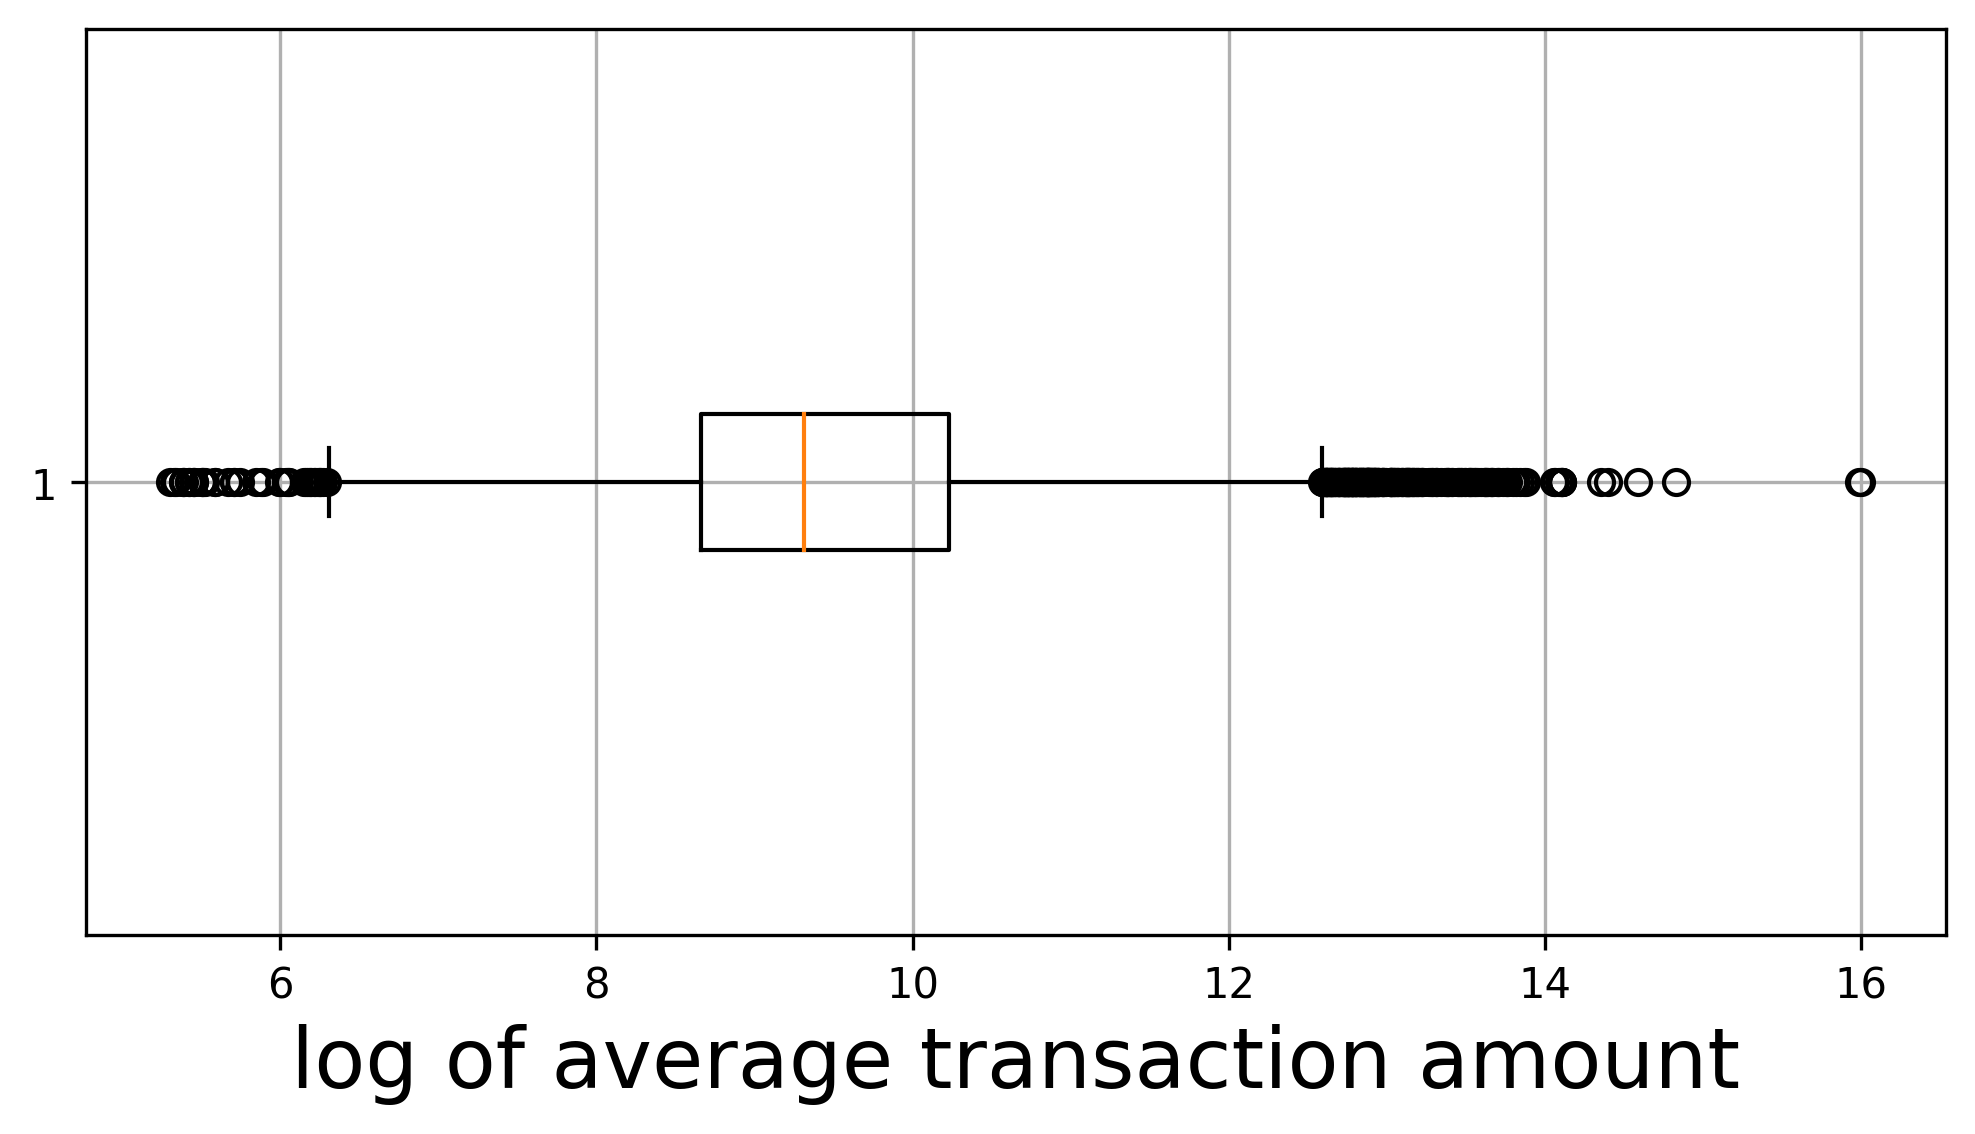

In [79]:
figure = plt.figure(figsize=(8, 4), dpi=300)
plt.boxplot(np.log(user.avg_amount), vert=False)
plt.xlabel(('log of average transaction amount'), size=20)
plt.grid()

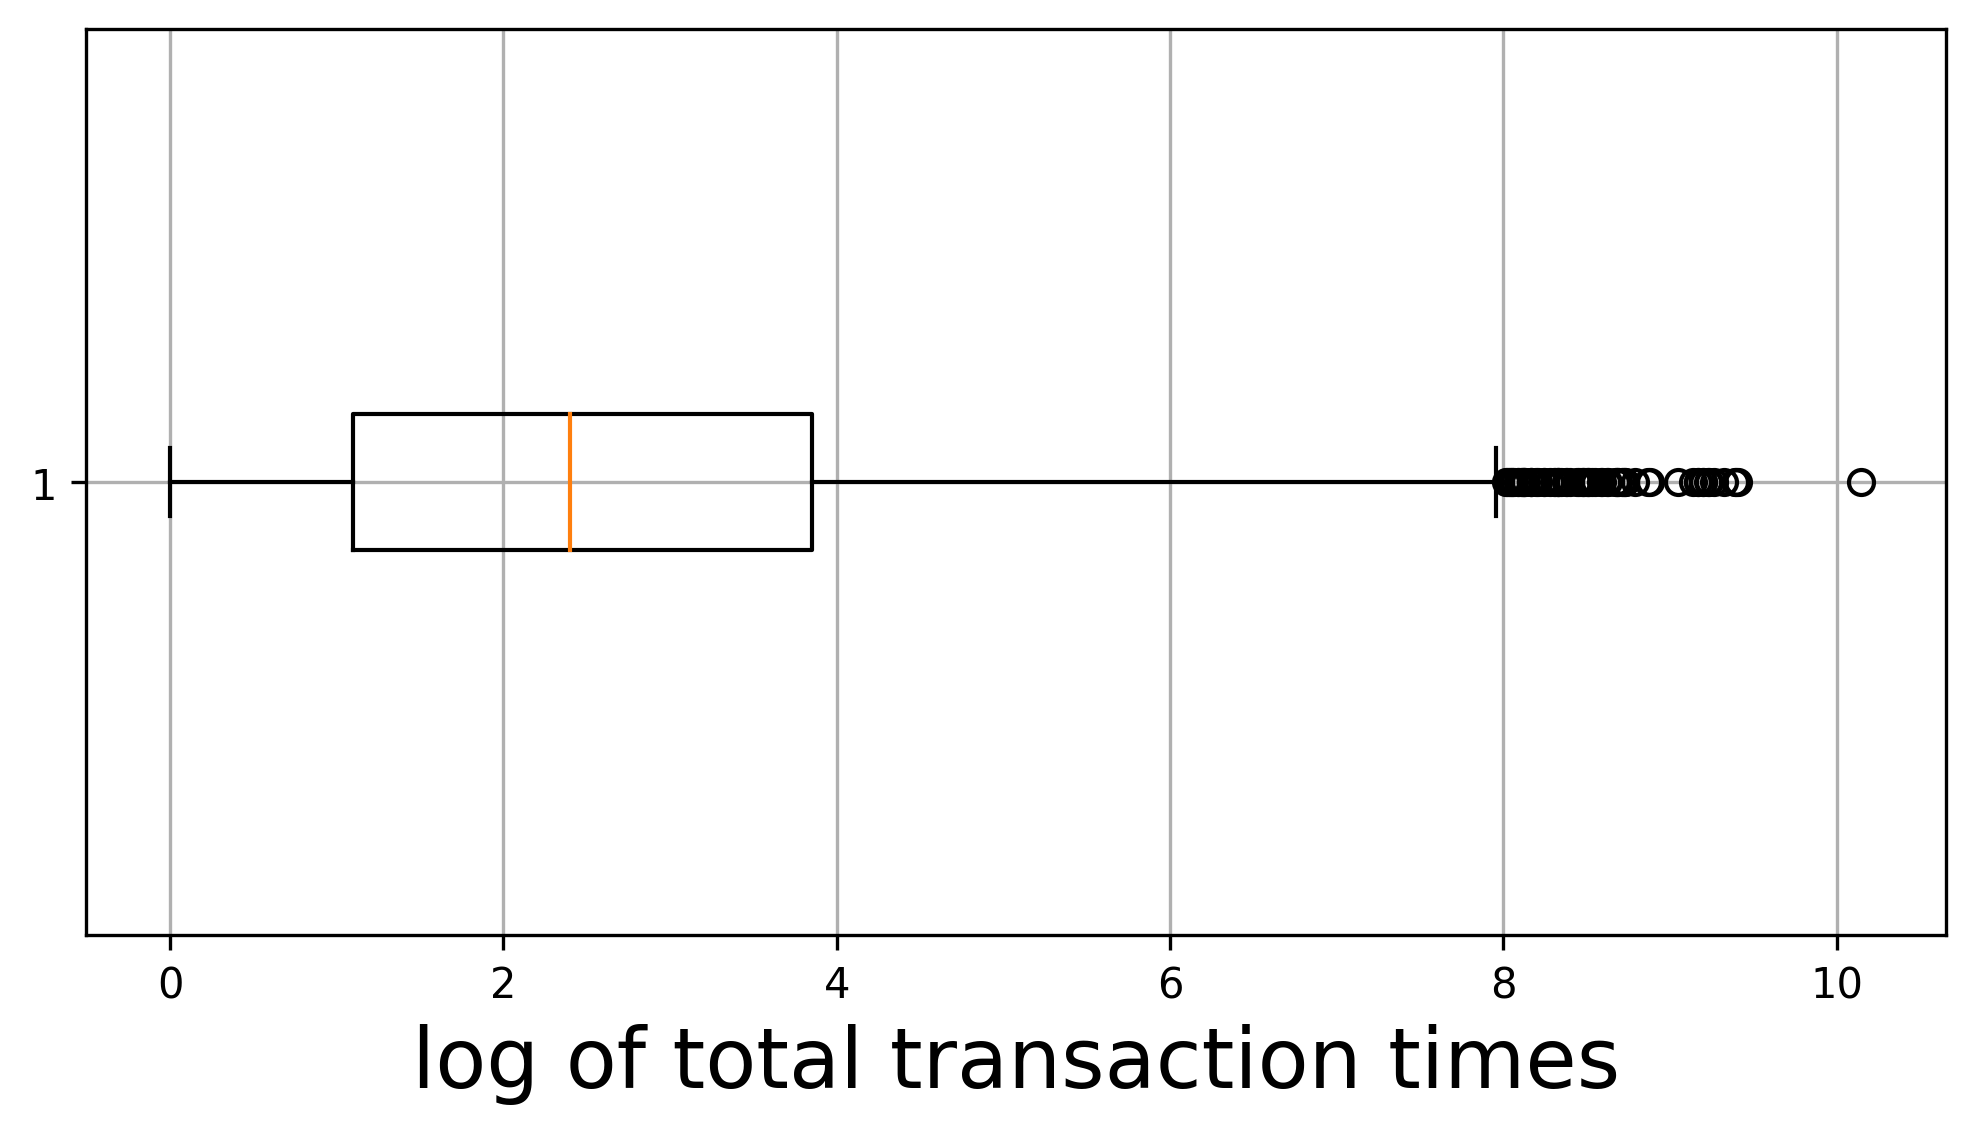

In [80]:
figure = plt.figure(figsize=(8, 4), dpi=300)
plt.boxplot(np.log(user.total_txn_times), vert=False)
plt.xlabel(('log of total transaction times'), size=20)
plt.grid()

In [44]:
# Therefore the data's variance is quite big

# implement an FM model to divide user group

In [45]:
# Basically i want to divide user group instead of predicting user churn altogether. 
# I believe there are some counfounders here.
# RFM does not perfectly match our situation so we only use FM model to divide user group.
# To devide the group based on some threshold, how to determine the threshold is a problem here.

In [46]:
# Firstly I wanna try a threshold that could distinguish the churn rate between the divided two groups. That
# is to calculate the relationship between the gap and the threshold.

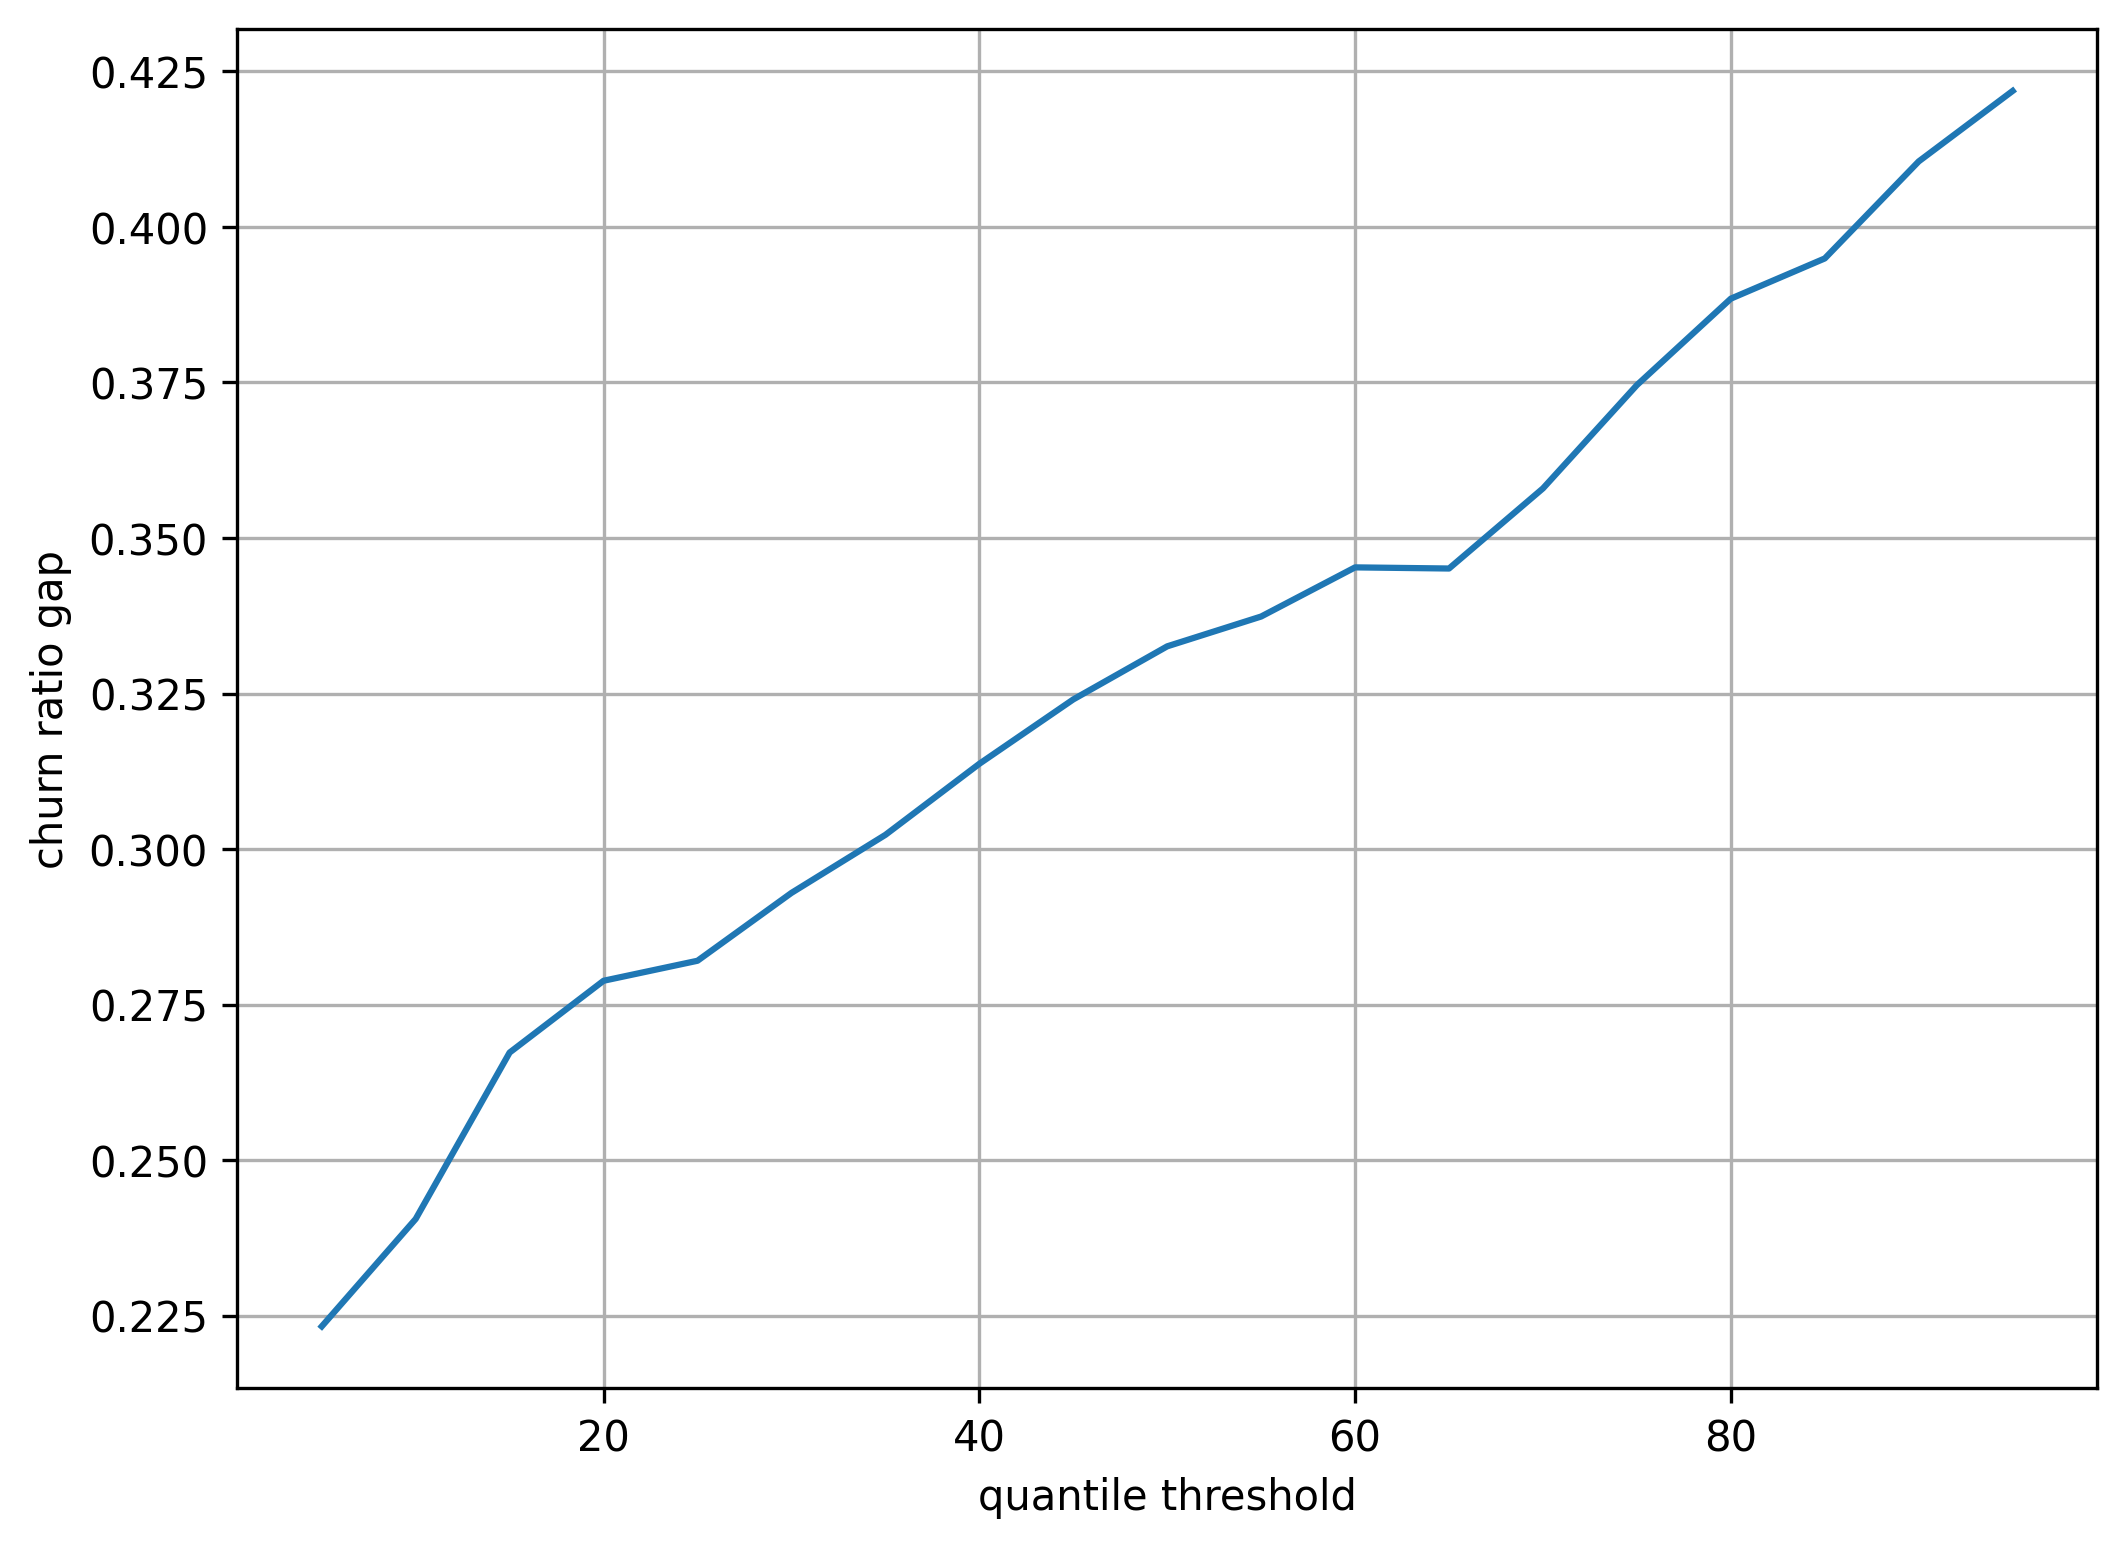

In [47]:
# for total amount
gap_list = []
for i in range(5, 100, 5):
    t = sorted(user.total_amount)[len(sorted(user.total_amount)) * i//100]
    gap = user[user['total_amount']<=t].churn.mean() - user[user['total_amount']>t].churn.mean()
    gap_list.append(gap)
figure = plt.figure(figsize=(8, 6), dpi=300)
plt.plot(range(5, 100, 5), gap_list)
plt.ylabel('churn ratio gap')
plt.xlabel('quantile threshold')
plt.grid()

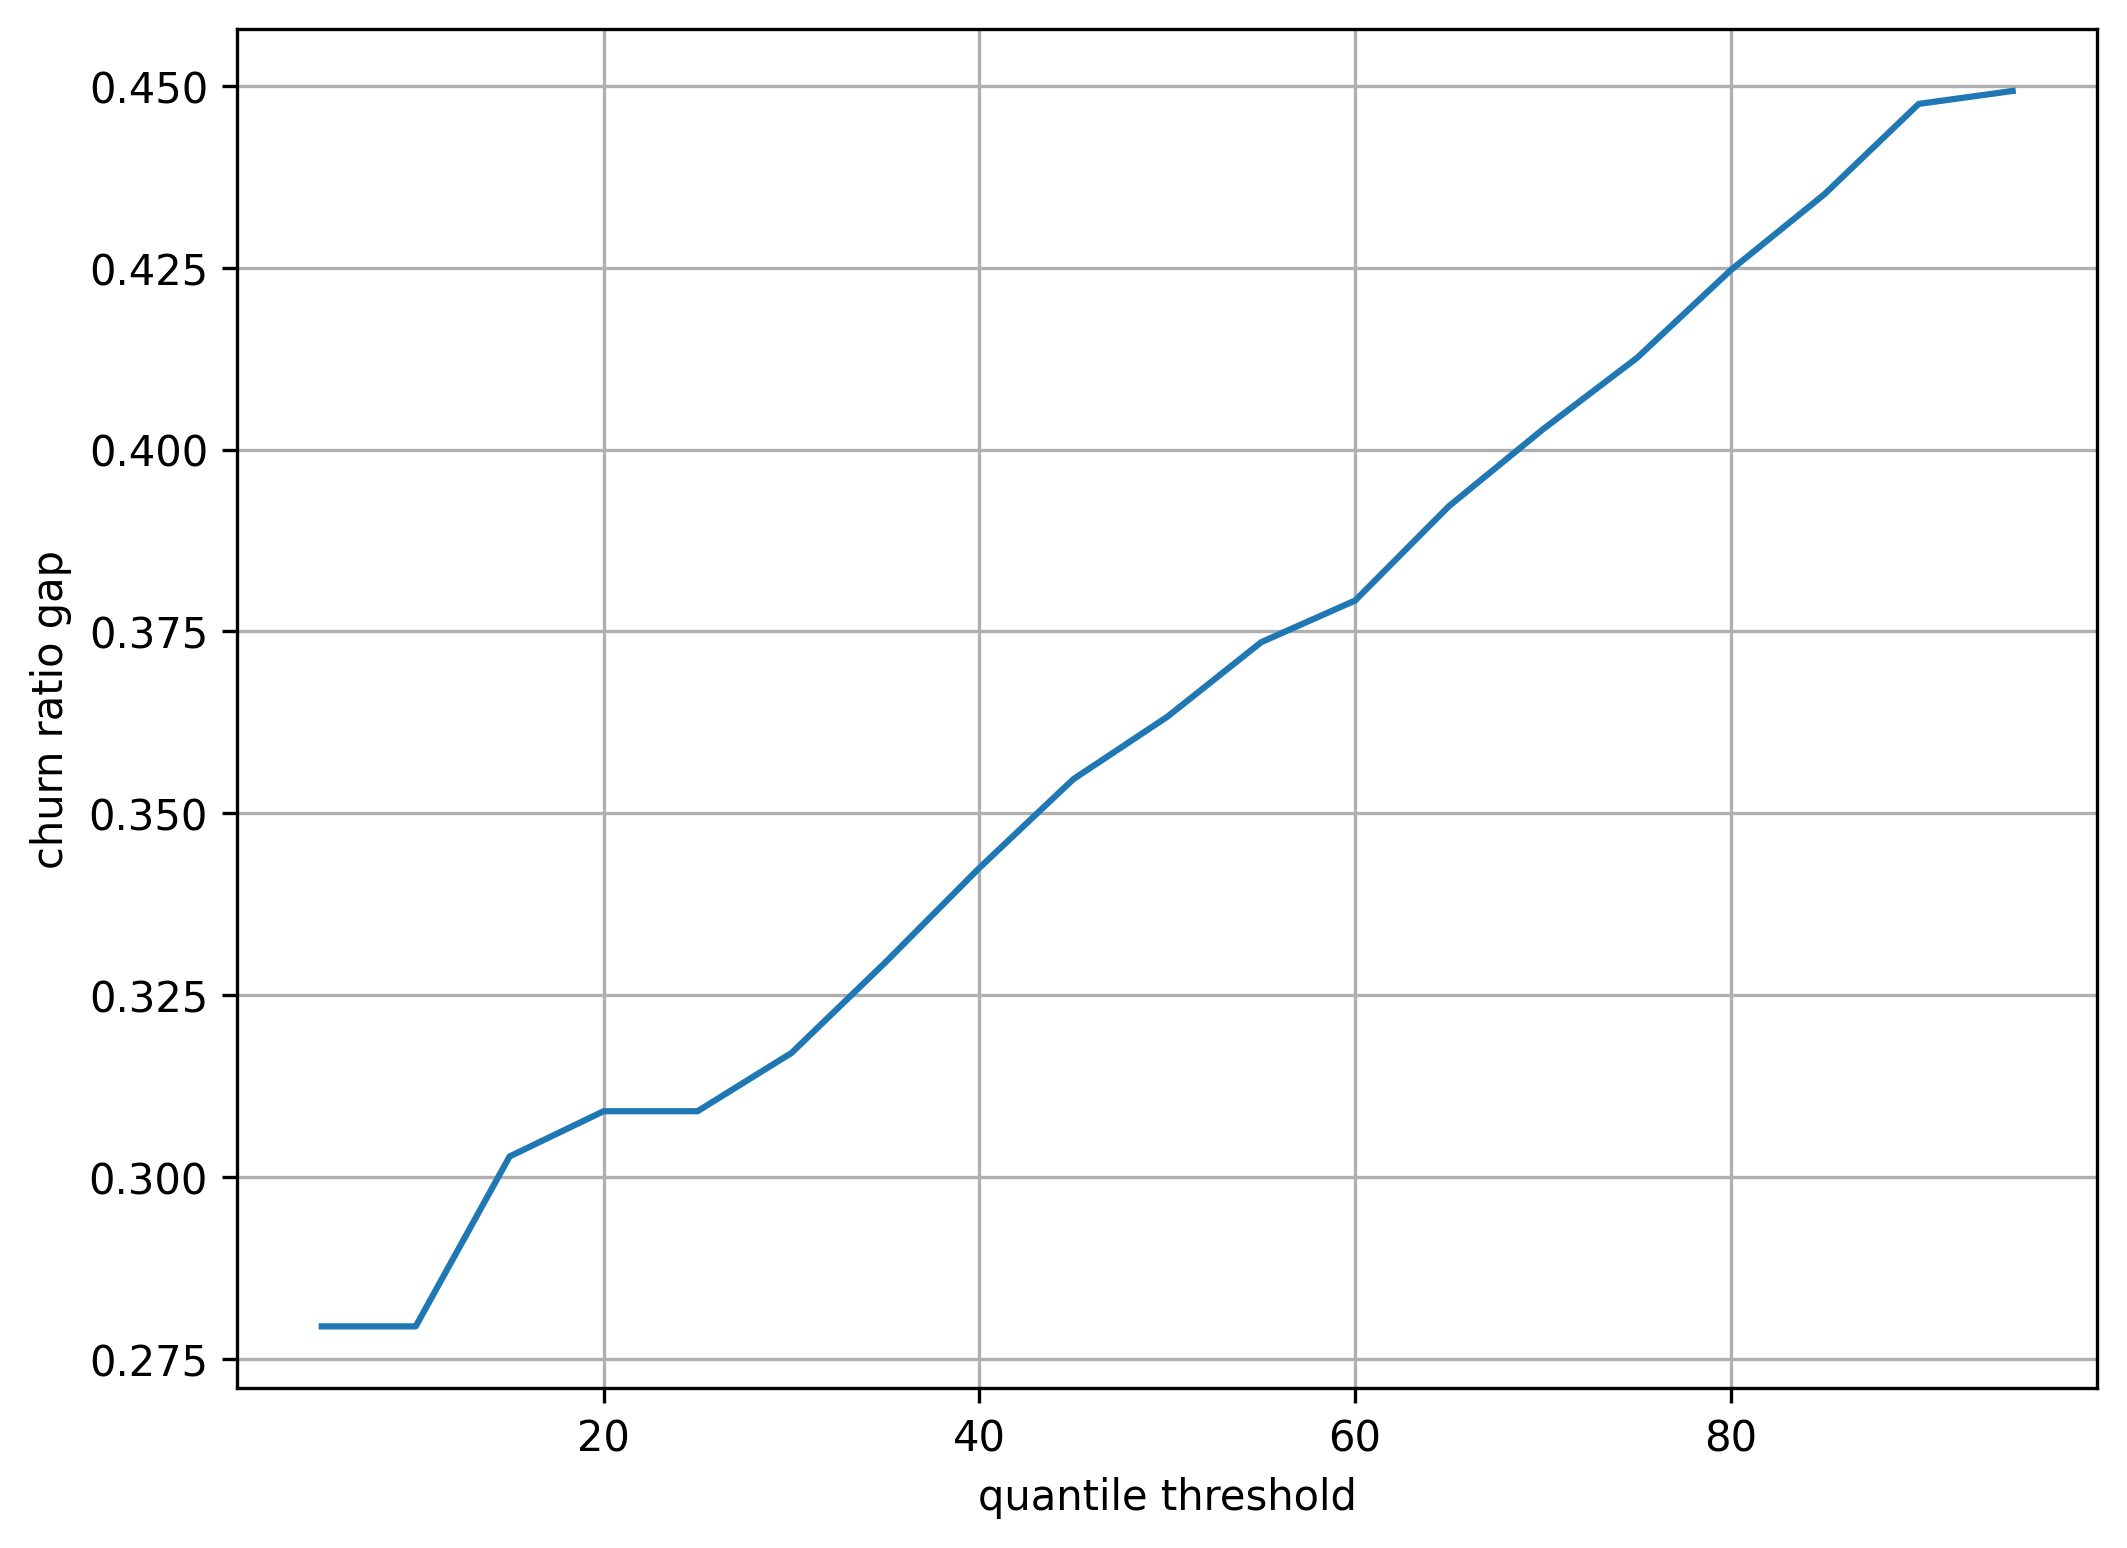

In [48]:
gap_list = []
for i in range(5, 100, 5):
    t = sorted(user.total_txn_times)[len(sorted(user.total_txn_times)) * i//100]
    gap = user[user['total_txn_times']<=t].churn.mean() - user[user['total_txn_times']>t].churn.mean()
    gap_list.append(gap)
figure = plt.figure(figsize=(8, 6), dpi=300)
plt.plot(range(5, 100, 5), gap_list)
plt.ylabel('churn ratio gap')
plt.xlabel('quantile threshold')
plt.grid()

In [49]:
# Unfortunately there is no optimal threshold. The curve is monotone.

In [50]:
# assign merchants into groups
user[['Frequency', 'Monetary']].to_csv('Merchant Business Type.csv')

In [51]:
def get_group_data(data, F=1, M=1):
    if F==-1 & M==-1:
        return data.reset_index(drop=True)
    da = data[(data['Frequency']==F)&(data['Monetary']==M)]
    print('===')
    print("For user with %s frequency and %s money. " % ('high' if F==1 else 'low', 'high' if M==1 else 'low'))
    if 'churn' in da.columns:
        print("Average churn rate: %.4f" % da.churn.mean())
    print("Data amount: %d" % da.shape[0])
    return da.reset_index(drop=True)

In [52]:
# See average churn rate in different type of merchants

In [77]:
for f in [1, 0]:
    for m in [1, 0]:
        get_group_data(user, f, m)

===
For user with high frequency and high money. 
Average churn rate: 0.1746
Data amount: 1890
===
For user with high frequency and low money. 
Average churn rate: 0.3365
Data amount: 850
===
For user with low frequency and high money. 
Average churn rate: 0.4294
Data amount: 850
===
For user with low frequency and low money. 
Average churn rate: 0.6680
Data amount: 10108


# For each group, select behaviors used for training model

In [54]:
def get_group_process_data(user, data, F=1, M=1):
    """Preprocess the group data, do feature engineering"""
    
    group_user = get_group_data(user, F, M)
    
    group_action = pd.merge(group_user.reset_index(drop=True), data.reset_index(drop=True), on='merchant')
    group_action['date_to_last'] = (group_action['last_txn_date'] - group_action['date']).dt.days
    
    # get past days' behaviors
    group_action_180_m = group_action[group_action['date_to_last']<180][['merchant', 'amount_usd_in_cents']].groupby(
        'merchant').sum().reset_index().rename(columns=
                                               {'amount_usd_in_cents': '180_amount_usd_in_cents'})
    group_action_180_f = group_action[group_action['date_to_last']<180][['merchant', 'date']].groupby(
        'merchant').count().reset_index().rename(columns={'date': '180_total_txn_times'})    
    
    group_action_90_m = group_action[group_action['date_to_last']<90][['merchant', 'amount_usd_in_cents']].groupby(
        'merchant').sum().reset_index().rename(columns=
                                               {'amount_usd_in_cents': '90_amount_usd_in_cents'})
    group_action_90_f = group_action[group_action['date_to_last']<90][['merchant', 'date']].groupby(
        'merchant').count().reset_index().rename(columns={'date': '90_total_txn_times'})    
    
    group_action_60_m = group_action[group_action['date_to_last']<60][['merchant', 'amount_usd_in_cents']].groupby(
        'merchant').sum().reset_index().rename(columns=
                                               {'amount_usd_in_cents': '60_amount_usd_in_cents'})
    group_action_60_f = group_action[group_action['date_to_last']<60][['merchant', 'date']].groupby(
        'merchant').count().reset_index().rename(columns={'date': '60_total_txn_times'})    
    
    group_action_30_m = group_action[group_action['date_to_last']<30][['merchant', 'amount_usd_in_cents']].groupby(
        'merchant').sum().reset_index().rename(columns=
                                               {'amount_usd_in_cents': '30_amount_usd_in_cents'})
    group_action_30_f = group_action[group_action['date_to_last']<30][['merchant', 'date']].groupby(
        'merchant').count().reset_index().rename(columns={'date': '30_total_txn_times'})    
        
    
    group_user = group_user.merge(
    group_action_180_m, on='merchant').merge(
    group_action_180_f, on='merchant').merge(
    group_action_90_m, on='merchant').merge(
    group_action_90_f, on='merchant').merge(
    group_action_60_m, on='merchant').merge(
    group_action_60_f, on='merchant').merge(
    group_action_30_m, on='merchant').merge(
    group_action_30_f, on='merchant')
    
    # feature engineering
    group_user['amount_hy_change'] = group_user['90_amount_usd_in_cents']/3 - (group_user['180_amount_usd_in_cents'] - group_user['90_amount_usd_in_cents'])/3
    group_user['amount_mn_change'] = group_user['30_amount_usd_in_cents'] - (group_user['60_amount_usd_in_cents'] - group_user['30_amount_usd_in_cents'])
    group_user['freq_hy_change'] = group_user['90_total_txn_times']/3 - (group_user['180_total_txn_times'] - group_user['90_total_txn_times'])/3
    group_user['freq_mn_change'] = group_user['30_total_txn_times'] - (group_user['60_total_txn_times'] - group_user['30_total_txn_times'])

    return group_user
    

# Let's wrap up our goal

So we have defined what churn is. That is a user has no txn for 30 days given a spot. In above statement, we define
the spot date is '2035-01-01'. Now our work is to predict user's churn, so how about users's behavior in the next
month? I want to divide the dataset into training set and test set. I set the spot date as '2034-12-01', and use the 
churn data at that spot date to train a model. Then predict users still active between '2034-12-01' to '2035-01-01'.
Predict whether they will churn in the next month.


# Training model

## Defines training set and test set.

In [55]:
spot = '2034-12-01'
user_train = preprocess_data(data[~(data['time']>=spot)], spot='2034-12-01')
user_train = user_train.reset_index(drop=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [56]:
user_train

merchant       last_txn_date     avg_amount  med_amount  \
0      faa029c6b0 2034-11-29 18:20:26   16730.129666     14599.0   
1      5608f200cf 2034-11-30 23:57:57     819.674113       820.0   
2      15b1a0d61e 2034-11-30 01:51:42    5779.366667      4466.0   
3      4770051790 2034-11-27 02:44:31   44515.161111     30126.0   
4      3fc4f08d9d 2034-11-28 21:32:47    5704.162991      6190.0   
...           ...                 ...            ...         ...   
13027  41f6054841 2034-03-11 00:45:57    1233.000000      1233.0   
13028  cce748c02b 2033-08-15 15:05:50  406528.000000    406528.0   
13029  9506efbbbd 2034-11-22 01:08:25   13536.000000     13536.0   
13030  7dd807a637 2033-12-13 15:16:21   31361.000000     31361.0   
13031  314ea3d710 2034-08-29 01:19:37    2068.000000      2068.0   

       total_amount  total_txn_times  gap_last_txn  churn  Frequency  Monetary  
0           8515636              509             1      0          1         1  
1          20363164            24843             0      0          1         1  
2           2774096              480             0      0          1         1  
3          24038187              540             3      0          1         1  
4          22502923             3945             2      0          1         1  
...             ...              ...           ...    ...        ...       ...  
13027          1233                1           264      1          0         0  
13028        406528                1           472      1          0         0  
13029         13536                1             8      0          0         0  
13030         31361                1           352      1          0         0  
13031          2068                1            93      1          0         0  

[13032 rows x 10 columns]

In [57]:
user_test = user[user['last_txn_date'] >= spot].reset_index(drop=True)
spot_new = '2035-01-01'
user_test['gap_last_txn'] = (pd.to_datetime(spot_new) - user_test['last_txn_date']).dt.days
user_test = user_test.drop(columns=['churn'])

In [58]:
user_test

merchant       last_txn_date    avg_amount  med_amount  total_amount  \
0     faa029c6b0 2034-12-30 20:57:25  16729.992647     14599.0       9101116   
1     ed7a7d91aa 2034-12-27 00:40:38  16958.500000      6492.0        271336   
2     5608f200cf 2034-12-31 04:44:54    819.675878       820.0      20911571   
3     15b1a0d61e 2034-12-30 21:21:42   5765.639155      4466.0       3003898   
4     4770051790 2034-12-31 02:52:53  45291.076655     28854.5      25997078   
...          ...                 ...           ...         ...           ...   
6121  cbe23f7e2c 2034-12-08 22:49:11  42201.000000     42201.0         42201   
6122  cb5a112bf4 2034-12-05 20:51:39  19353.000000     19353.0         19353   
6123  6657e4d6a3 2034-12-03 20:27:46   3347.000000      3347.0          3347   
6124  f2c5206eb6 2034-12-26 19:33:18    401.000000       401.0           401   
6125  00607c6461 2034-12-21 15:02:45  50094.000000     50094.0         50094   

      total_txn_times  gap_last_txn  Frequency  Monetary  
0                 544             1          1         1  
1                  16             4          0         0  
2               25512             0          1         1  
3                 521             1          1         1  
4                 574             0          1         1  
...               ...           ...        ...       ...  
6121                1            23          0         0  
6122                1            26          0         0  
6123                1            28          0         0  
6124                1             5          0         0  
6125                1            10          0         0  

[6126 rows x 9 columns]

## split training set and validation set and train the model

In [107]:
def train_model(F, M):

    group_user = get_group_process_data(user_train, data, F, M)
    group_user_test = get_group_process_data(user_test, data, F, M)

    columns = [
        'amount_hy_change', 
        'amount_mn_change',
        'freq_hy_change',
        'freq_mn_change',
        '30_total_txn_times',
        '60_total_txn_times',
        '90_total_txn_times',
        '180_total_txn_times',
        '30_amount_usd_in_cents',
        '60_amount_usd_in_cents',
        '90_amount_usd_in_cents',
        '180_amount_usd_in_cents'
    ]

    X, y = group_user[columns], group_user['churn']

    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify = y)  

    param_grid = { 
        'n_estimators': [10, 30, 50, 100, 200, 300, 400],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
        'criterion': ['gini', 'entropy']
    }

    scorers = {
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'accuracy_score': make_scorer(accuracy_score)
    }

    # I use recall as the main metric to evaluate performance
    # rfc = GridSearchCV(, param_grid, scoring=scorers, refit='recall_score', cv=5)
    rfc = RandomizedSearchCV(estimator=RandomForestClassifier(), 
                       param_distributions=param_grid, 
                       scoring=scorers, 
                       refit='recall_score', 
                       n_iter=100, 
                       cv=5, 
                       verbose=2, 
                       n_jobs = -1)
    rfc.fit(X_train, y_train)

    print(rfc.score(X_val, y_val))
    print(rfc.best_params_)
    print(classification_report(y_val, rfc.predict(X_val)))

    test_set = group_user_test[columns]

    best_rfc = RandomForestClassifier(
        max_depth=rfc.best_params_['max_depth'],
        n_estimators=rfc.best_params_['n_estimators']
    )
    best_rfc.fit(X_train, y_train)

    fig = plt.figure(figsize=(12, 8), dpi=800)
    feature_data = pd.DataFrame([X_train.columns, best_rfc.feature_importances_], index=['features', 'importance']).T
    feature_data = feature_data.sort_values(by='importance')
    plt.barh(feature_data['features'], feature_data['importance'])
    plt.ylabel('Features', size=20)
    plt.xlabel("Imoprtance index", size=20)
    plt.grid()

    test_set['churn'] = rfc.predict(test_set[columns])
    test_set['merchant'] = group_user_test['merchant']

    test_outcome = test_set[['merchant', 'churn']]
    
    return test_outcome, best.predict(X_val), y_val

===
For user with high frequency and high money. 
Average churn rate: 0.1769
Data amount: 1792
===
For user with high frequency and high money. 
Data amount: 1565
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


0.46875
{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 70, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       295
           1       0.64      0.47      0.54        64

    accuracy                           0.86       359
   macro avg       0.76      0.71      0.73       359
weighted avg       0.85      0.86      0.85       359




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


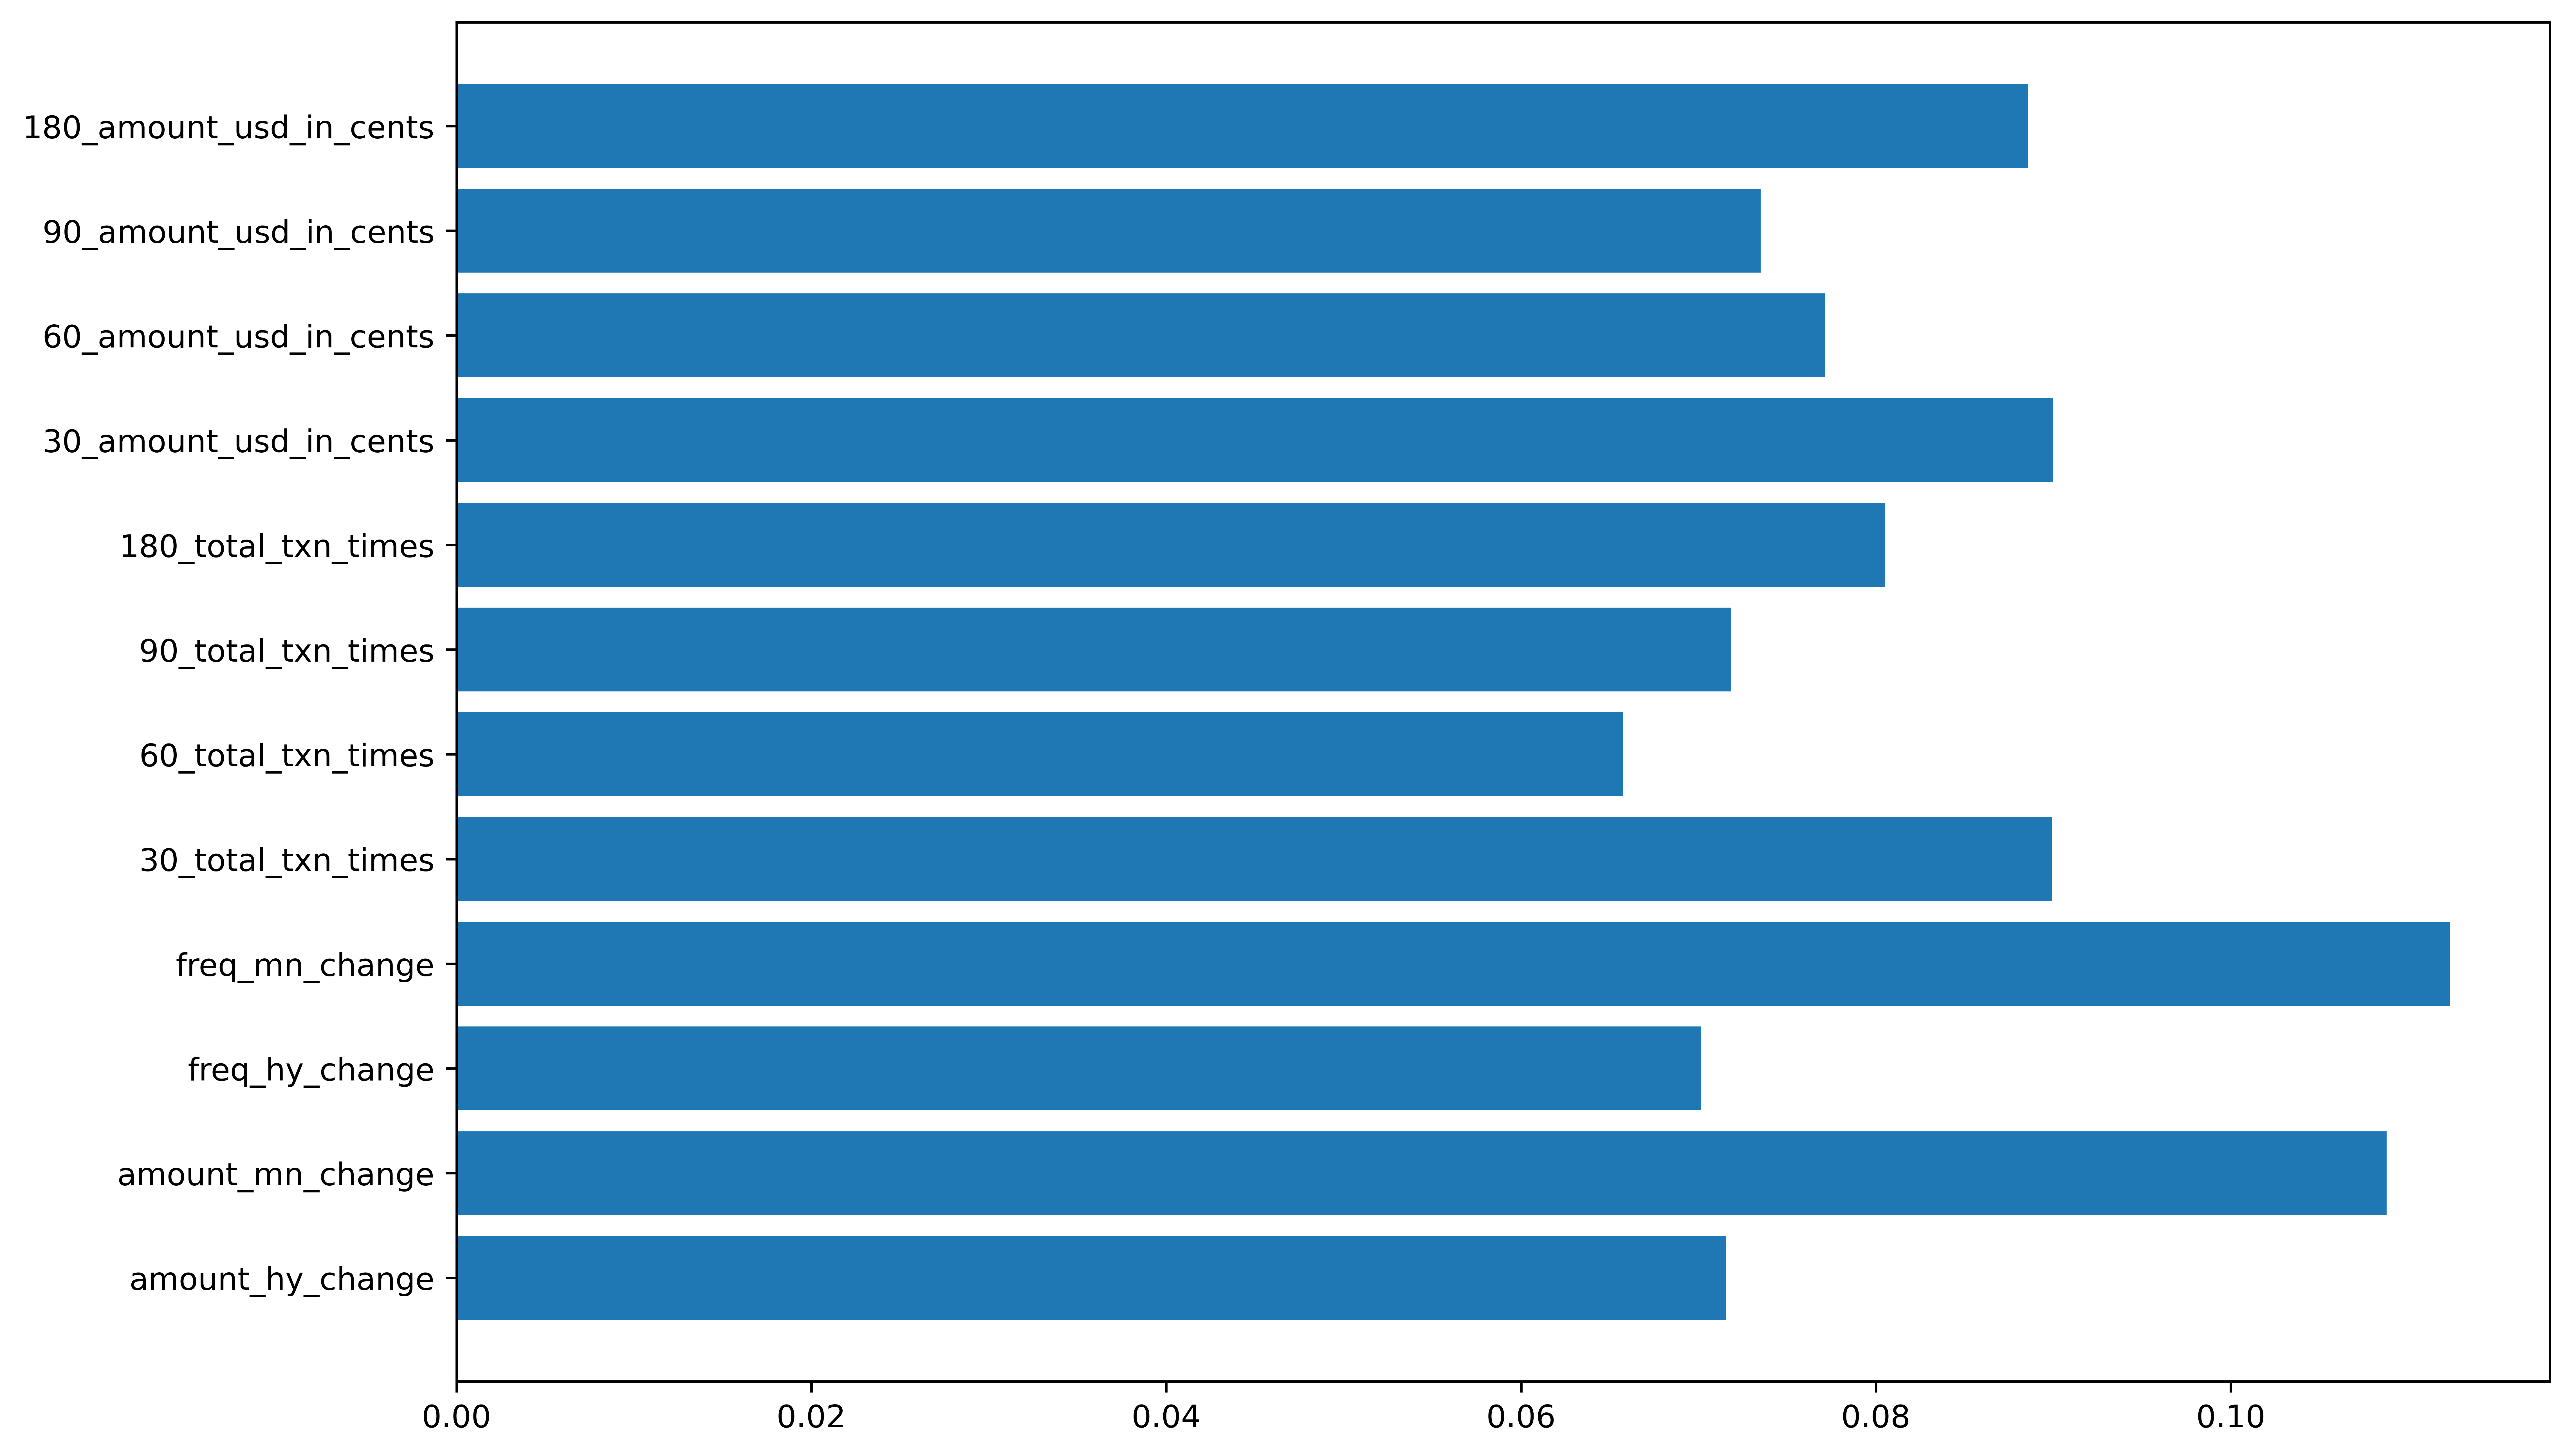

In [81]:
# F = M = 1

# group_user = get_group_process_data(user_train, data, F, M)
# group_user_test = get_group_process_data(user_test, data, F, M)

# columns = [
#     'amount_hy_change', 
#     'amount_mn_change',
#     'freq_hy_change',
#     'freq_mn_change',
#     '30_total_txn_times',
#     '60_total_txn_times',
#     '90_total_txn_times',
#     '180_total_txn_times',
#     '30_amount_usd_in_cents',
#     '60_amount_usd_in_cents',
#     '90_amount_usd_in_cents',
#     '180_amount_usd_in_cents'
# ]

# X, y = group_user[columns], group_user['churn']

# X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify = y)  

# param_grid = { 
#     'n_estimators': [10, 30, 50, 100, 200, 300, 400],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
#     'criterion': ['gini', 'entropy']
# }

# scorers = {
#     'precision_score': make_scorer(precision_score),
#     'recall_score': make_scorer(recall_score),
#     'accuracy_score': make_scorer(accuracy_score)
# }

# # I use recall as the main metric to evaluate performance
# # rfc = GridSearchCV(, param_grid, scoring=scorers, refit='recall_score', cv=5)
# rfc = RandomizedSearchCV(estimator=RandomForestClassifier(), 
#                    param_distributions=param_grid, 
#                    scoring=scorers, 
#                    refit='recall_score', 
#                    n_iter=100, 
#                    cv=5, 
#                    verbose=2, 
#                    n_jobs = -1)
# rfc.fit(X_train, y_train)

# print(rfc.score(X_val, y_val))
# print(rfc.best_params_)
# print(classification_report(y_val, rfc.predict(X_val)))

# test_set = group_user_test[columns]

# best_rfc = RandomForestClassifier(
#     max_depth=rfc.best_params_['max_depth'],
#     n_estimators=rfc.best_params_['n_estimators']
# )
# best_rfc.fit(X_train, y_train)

# fig = plt.figure(figsize=(12, 8), dpi=800)
# plt.barh(X_train.columns, best_rfc.feature_importances_)

# test_set['churn'] = rfc.predict(test_set[columns])
# test_set['merchant'] = group_user_test['merchant']

# test_outcome = test_set[['merchant', 'churn']]

## Run models on 4 types of merchants

In [127]:
outcome = []
outcome_all = []
for f in [1, 0]:
    for m in [1, 0]:
        oc = train_model(f, m)
        outcome.append(oc[0])
        outcome_all.append(oc)


===
For user with high frequency and high money. 
Average churn rate: 0.1769
Data amount: 1792
===
For user with high frequency and high money. 
Data amount: 1565
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   57.5s finished


0.46875
{'n_estimators': 100, 'max_features': 'auto', 'max_depth': 80, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       295
           1       0.64      0.47      0.54        64

    accuracy                           0.86       359
   macro avg       0.76      0.71      0.73       359
weighted avg       0.85      0.86      0.85       359




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


===
For user with high frequency and low money. 
Average churn rate: 0.3358
Data amount: 798
===
For user with high frequency and low money. 
Data amount: 568
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   44.8s finished


0.5185185185185185
{'n_estimators': 300, 'max_features': 'auto', 'max_depth': 60, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       106
           1       0.68      0.52      0.59        54

    accuracy                           0.76       160
   macro avg       0.73      0.70      0.71       160
weighted avg       0.75      0.76      0.75       160




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


===
For user with low frequency and high money. 
Average churn rate: 0.3669
Data amount: 815
===
For user with low frequency and high money. 
Data amount: 533
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   36.7s finished


0.4166666666666667
{'n_estimators': 200, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.69      0.76      0.72       103
           1       0.50      0.42      0.45        60

    accuracy                           0.63       163
   macro avg       0.60      0.59      0.59       163
weighted avg       0.62      0.63      0.62       163




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


===
For user with low frequency and low money. 
Average churn rate: 0.6433
Data amount: 9627
===
For user with low frequency and low money. 
Data amount: 3460
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.8min finished


0.8853914447134786
{'n_estimators': 400, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.66      0.40      0.50       687
           1       0.73      0.89      0.80      1239

    accuracy                           0.71      1926
   macro avg       0.69      0.64      0.65      1926
weighted avg       0.70      0.71      0.69      1926




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Output result

In [175]:
# what if no confounder exclusion

In [109]:
oc = train_model(-1, -1)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.3min finished


0.8241525423728814
{'n_estimators': 400, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.74      0.60      0.66      1191
           1       0.71      0.82      0.76      1416

    accuracy                           0.72      2607
   macro avg       0.73      0.71      0.71      2607
weighted avg       0.72      0.72      0.72      2607




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [170]:
final_result = pd.concat([outcome[i] for i in range(4)])[['merchant', 'churn']]
final_result = final_result.merge(user_test[['merchant', 'Frequency', 'Monetary']], on='merchant')
final_result.to_csv('final churn prediction update.csv', index=False)

In [171]:
# calculation on validation set performance between excluding confounders and not

In [176]:
p = []
true_predict = 0
all_user = 0
for i in range(4):
    true_predict += (outcome_all[0][2] == outcome_all[0][1]).mean() * len(outcome_all[0][2])
    all_user += len(outcome_all[0][2])

In [177]:
true_predict / all_user

0.871866295264624

In [178]:
(oc[2] == oc[1]).mean()

0.7102803738317757